# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import scipy.linalg
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
        self.EMBEDDING_SHAPE = self.embeddings[0].shape
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        try:
            return self.embeddings[self.word2id[word]]
        except KeyError:
            return np.zeros(self.EMBEDDING_SHAPE)
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        embed1, embed2 = self.encode(word1), self.encode(word2)
        return np.dot(embed1/np.linalg.norm(embed1), embed2/np.linalg.norm(embed2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        scores = [self.score(word, word2) if word != word2 else 0 for word2 in self.words]
        k_similars = np.argsort(np.array(scores))[-1:-k-1:-1]
        # [-1:-k-1:-1] to select the k words with the highest similarity, decreasing order of similarity.
        
        return [self.id2word[simil] for simil in k_similars]

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542561
cat pet 0.6753313359976383
Paris France 0.689295892580654
Paris Germany 0.40512422867375486
Paris baguette 0.2939995827780223
Paris donut -0.0065885075523479915
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        D = np.log(len(sentences))
        
        word_count = {word: 0 for word in self.word2vec.words}
        for sentence in sentences:
            for word in list(set(sentence.strip().split(" "))):
                try:
                    word_count[word] += 1
                except KeyError:
                    word_count[word] = 0
        
        idf = {word: D - np.log(word_count[word]+1e-9) for word in self.word2vec.words}  # + 1e-9 to avoid having 0 in the log.
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        if idf is None:
            # mean of word vectors
            # raise NotImplementedError('Fill in the blank')
            return np.mean([self.word2vec.encode(word) for word in sentence.strip().split(' ')], axis=0)
        else:
            # idf-weighted mean of word vectors
            # raise NotImplementedError('Fill in the blank')
            return np.mean([idf.get(word, 0)*self.word2vec.encode(word) for word in sentence.strip().split(' ')], axis=0)

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        # raise NotImplementedError('Fill in the blank')
        embed1, embed2 = self.encode(sentence1, idf=idf), self.encode(sentence2, idf=idf)
        return np.dot(embed1, embed2) / (np.linalg.norm(embed1) * np.linalg.norm(embed2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        # raise NotImplementedError('Fill in the blank')
        scores = [self.score(sentence, sentence2, idf=idf) if sentence != sentence2 else 0 for sentence2 in sentences]
        k_similars = np.argsort(np.array(scores))[-1:-k-1:-1]
        # [-2:-k-2:-1] to select the k words with the highest similarity, in decreasing order of similarity.
        return [sentences[arg] for arg in k_similars]

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939347016
a young boy and 2 girls open christmas presents . 
1) 3 girls and one boy playing in the street . 
2) a group of friends , 3 boys and 2 girls , jump in the air holding hands for a photo . 
3) five children , 3 boys and 2 girls playing soccer in a grass field . 
4) 2 young indian girls dressed in colorful dresses walking . 
5) 2 kids holding hands and smiling . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        # raise NotImplementedError('Fill in the blank')
        fr_words = set(self.fr_word2vec.words)
        en_words = set(self.en_word2vec.words)
        common_words = fr_words.intersection(en_words)
        X = np.array([self.fr_word2vec.encode(word) for word in common_words]).T
        Y = np.array([self.en_word2vec.encode(word) for word in common_words]).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        # raise NotImplementedError('Fill in the blank')
        U, E, Vt = scipy.linalg.svd(np.dot(Y, X.T))
        W = np.dot(U, Vt)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        # raise NotImplementedError('Fill in the blank')
        fr_word_align_embed = self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]]
        scores = [np.dot(fr_word_align_embed, embed)/(np.linalg.norm(embed)*np.linalg.norm(fr_word_align_embed)) for embed in self.en_word2vec.embeddings]
        output = np.argsort(scores)[-1:-k-1:-1]
        return [self.en_word2vec.id2word[w] for w in output]

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE
with open(train_filepath, 'r') as f:
    train_samples = [(line.strip('\n').split(" ", 1)) for line in f]
    train_sentences = [sample[1] for sample in train_samples]
    train_labels = [int(sample[0]) for sample in train_samples]
    train_sentence2id = {sentence: i for i, sentence in enumerate(train_sentences)}
    train_id2sentence = {i: sentence for i, sentence in enumerate(train_sentences)}

with open(dev_filepath, 'r') as f:
    dev_samples = [(line.strip('\n').split(" ", 1)) for line in f]
    dev_sentences = [sample[1] for sample in dev_samples]
    dev_labels = [int(sample[0]) for sample in dev_samples]
    dev_sentence2id = {sentence: i for i, sentence in enumerate(dev_sentences)}
    dev_id2sentence = {i: sentence for i, sentence in enumerate(dev_sentences)}

with open(test_filepath, 'r') as f:
    test_sentences = [line.strip('\n') for line in f]
    test_sentence2id = {sentence: i for i, sentence in enumerate(test_sentences)}
    test_id2sentence = {i: sentence for i, sentence in enumerate(test_sentences)}

In [10]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
word2vec = Word2Vec(en_embeddings_path, vocab_size=500000)
sentence2vec = BagOfWords(word2vec)

train_embeddings = [sentence2vec.encode(sentence) for sentence in train_sentences]
dev_embeddings = [sentence2vec.encode(sentence) for sentence in dev_sentences]
test_embeddings = [sentence2vec.encode(sentence) for sentence in test_sentences]

idf_train = sentence2vec.build_idf(train_sentences)
train_embeddings_idf = [sentence2vec.encode(sentence, idf=idf) for sentence in train_sentences]

idf_dev = sentence2vec.build_idf(dev_sentences)
dev_embeddings_idf = [sentence2vec.encode(sentence, idf=idf) for sentence in dev_sentences]

idf_test = sentence2vec.build_idf(test_sentences)
test_embeddings_idf = [sentence2vec.encode(sentence, idf=idf) for sentence in test_sentences]

Loaded 500000 pretrained word vectors


In [11]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
#C = [0.9, 4.9, 10, 100, 1000]
C = [10]
print("No IDF:")
for c in C :
    clf1 = LogisticRegression(random_state=0, max_iter=500, solver='lbfgs',multi_class='multinomial',C=c).fit(train_embeddings, train_labels)
    print(str(c)+ " : " +str(clf1.score(dev_embeddings, dev_labels)))
print(str(c)+ " : " +str(clf1.score(train_embeddings, train_labels)))
C = [0.3]
print("With IDF:")
for c in C :
    clf2 = LogisticRegression(random_state=0, max_iter=500, solver='lbfgs',multi_class='multinomial',C=c).fit(train_embeddings_idf, train_labels)
    print(str(c)+ " : " +str(clf2.score(dev_embeddings_idf, dev_labels)))
print(str(c)+ " : " +str(clf1.score(train_embeddings_idf, train_labels)))

No IDF:
10 : 0.43505903723887374
10 : 0.48092228464419473
With IDF:
0.3 : 0.40054495912806537
0.3 : 0.4109316479400749


In [12]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
test_pred = clf1.predict(test_embeddings)
test_pred_idf = clf2.predict(test_embeddings_idf)

path_to_test_pred = 'logreg_bow_y_test_sst.txt'
np.savetxt(path_to_test_pred, test_pred, delimiter=',', fmt='%d')

In [13]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import tensorflow as tf

In [15]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from tensorflow.keras.preprocessing.text import one_hot

vocab_size = 50000

train_one_hot = [one_hot(sentence, vocab_size) for sentence in train_sentences]
dev_one_hot = [one_hot(sentence, vocab_size) for sentence in dev_sentences]
test_one_hot = [one_hot(sentence, vocab_size) for sentence in test_sentences]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [16]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_one_hot = pad_sequences(train_one_hot, padding='pre')
dev_one_hot = pad_sequences(dev_one_hot, padding='pre')
test_one_hot = pad_sequences(test_one_hot, padding='pre')

## 4.2 - Design and train your model

In [17]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [18]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 1,625,157
Trainable params: 1,625,157
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 11s 1ms/sample - loss: 1.5752 - accuracy: 0.2748 - val_loss: 1.5694 - val_accuracy: 0.2534
Epoch 2/6
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5187 - accuracy: 0.3301 - val_loss: 1.4747 - val_accuracy: 0.3706
Epoch 3/6
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.2915 - accuracy: 0.4360 - val_loss: 1.3800 - val_accuracy: 0.3887
Epoch 4/6
8544/8544 [==============================] - 11s 1ms/sample - loss: 1.0646 - accuracy: 0.5304 - val_loss: 1.4510 - val_accuracy: 0.3951
Epoch 5/6
8544/8544 [==============================] - 10s 1ms/sample - loss: 0.8649 - accuracy: 0.6573 - val_loss: 1.5989 - val_accuracy: 0.3688
Epoch 6/6
8544/8544 [==============================] - 10s 1ms/sample - loss: 0.6696 - accuracy: 0.7564 - val_loss: 1.8023 - val_accuracy: 0.3579


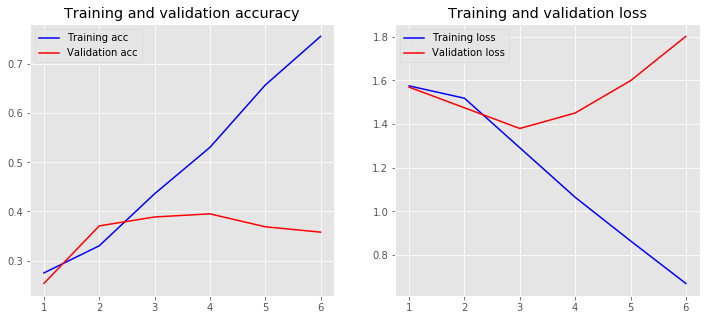

In [19]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 6

from tensorflow.keras.utils import to_categorical

x_train = train_one_hot
y_train = to_categorical(train_labels, dtype='uint8')

x_dev = dev_one_hot
y_dev = to_categorical(dev_labels, dtype='uint8')

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [20]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
x_test = test_one_hot
y_test = np.argmax(model.predict(x_test),axis=1)
path_to_y_test = 'logreg_lstm_y_test_sst.txt'
np.savetxt(path_to_y_test, y_test, delimiter=',', fmt='%d')

## 4.3 - innovate !

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          3200000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          24640     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)               

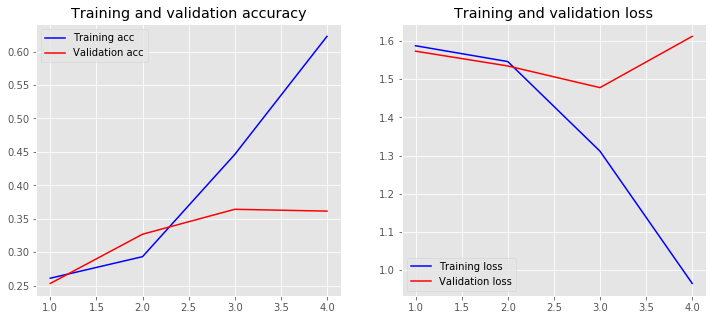

In [22]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Conv1D, GlobalMaxPooling1D, MaxPooling1D

embed_dim  = 64  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
#model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(LSTM(int(nhid/4), dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(nhid/4, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

#-------------------------------

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

#-------------------------------

bs = 64
n_epochs = 6

from tensorflow.keras.utils import to_categorical

x_train = train_one_hot
y_train = to_categorical(train_labels, dtype='uint8')

x_dev = dev_one_hot
y_dev = to_categorical(dev_labels, dtype='uint8')

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev), callbacks=[es])
plot_history(history)

#--------------------------

x_test = test_one_hot
y_test = np.argmax(model.predict(x_test),axis=1)
path_to_y_test = 'logreg_conv_y_test_sst.txt'
np.savetxt(path_to_y_test, y_test, delimiter=',', fmt='%d')